# Tropical Cyclone Characteristics Notebook

This notebook supports the research paper:

**"Characteristics of Tropical Cyclone within Philippine Operational Domains"**  
by Bernard Alan B. Racoma et al.

---

## Description

This notebook processes and analyzes tropical cyclone (TC) data over the Philippines, with a focus on behavior within operational domains such as the PAR, TCID, TCAD, and the Philippine Coastal Waters (PCW). It calculates statistics such as TC lifetimes, intensity changes, and landfall characteristics, and visualizes these with geospatial plots.

---

## Overview

1. **Setup** – Import libraries and define file paths.  
2. **Preprocessing** – Load and clean IBTrACS and shapefile data.  
3. **Analysis** – Calculate lifetimes, intensity change, RI events, etc.  
4. **Geospatial Processing** – Perform spatial joins and intersections.  
5. **Visualization** – Plot tracks, maps, and other figures.  
6. **Summary Statistics** – Output descriptive stats for reporting.  
7. **Conclusion** – Summary of findings and links to paper results.





## Imports

In [18]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, LineString
from shapely.prepared import prep
from shapely.ops import split
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
# import shapely

## Load data files

In [2]:
# Load the Philippine waters shapefile
phil_waters = gpd.read_file("/home/cs-iesm-geostorm/Data/gis/vector/boundaries/waters/philippine_waters_filled.shp")
ph_shape = phil_waters.geometry.iloc[0]

# ph_buffered = ph_shape.buffer(0.5)  # 0.5 degrees (since CRS is EPSG:4326)
phil_coast = gpd.read_file("/home/cs-iesm-geostorm/Data/gis/vector/boundaries/country/Country.shp")

ERROR! Session/line number was not unique in database. History logging moved to new session 2


ERROR 1: PROJ: proj_create_from_database: Open of /home/cs-iesm-geostorm/WRF_Intel/miniconda3/envs/research/share/proj failed


In [3]:
# Load TCID, TCAD, and PAR polygons
gdf_tcid = gpd.read_file("PAGASA_TCID.gpkg").to_crs(4326)
gdf_tcad = gpd.read_file("PAGASA_TCAD.gpkg").to_crs(4326)
gdf_par = gpd.read_file("PAGASA_PAR.gpkg").to_crs(4326)


In [4]:
# Load the IBTrACS data CSV
ibtracs = pd.read_csv("/home/cs-iesm-geostorm/Data/gis/vector/ibtracs/ibtracs.WP.list.v04r01.csv", low_memory=False ,skiprows = [1])
ibtracs = ibtracs[ibtracs.SEASON>=1979]
# Get unique storm IDs
unique_sids = ibtracs["SID"].unique()

In [6]:
len(unique_sids)

1507

In [5]:
# Convert to GeoDataFrame
gdf_tracks = gpd.GeoDataFrame(
    ibtracs,
    geometry=gpd.points_from_xy(ibtracs["LON"], ibtracs["LAT"]),
    crs="EPSG:4326"
)

## Calculate TC Intersections

In [12]:
from shapely.geometry import LineString
from shapely.prepared import prep

par_poly = gdf_par.geometry[0]
# Prepare the PH and PAR polygons
ph_prepared = prep(ph_shape)
par_prepared = prep(par_poly)

# Also get their bounding boxes for a fast first filter
ph_bounds = ph_shape.bounds
par_bounds = par_poly.bounds

intersect_results = []

for sid, group in tqdm(gdf_tracks.groupby("SID")):
    points = list(group.sort_values("ISO_TIME")["geometry"])
    if len(points) < 2:
        continue  # Skip storms with insufficient points

    track_line = LineString(points)
    line_bounds = track_line.bounds

    # Fast bounding box skip
    skip_ph = (line_bounds[2] < ph_bounds[0]) or (line_bounds[0] > ph_bounds[2]) or \
              (line_bounds[3] < ph_bounds[1]) or (line_bounds[1] > ph_bounds[3])

    skip_par = (line_bounds[2] < par_bounds[0]) or (line_bounds[0] > par_bounds[2]) or \
               (line_bounds[3] < par_bounds[1]) or (line_bounds[1] > par_bounds[3])

    # Use prepped geometry for faster intersects
    intersects_ph = False if skip_ph else ph_prepared.intersects(track_line)
    intersects_par = False if skip_par else par_prepared.intersects(track_line)

    intersect_results.append({
        "SID": sid,
        "intersects_ph": intersects_ph,
        "intersects_par": intersects_par
    })

# Wrap in DataFrame
df_intersects = pd.DataFrame(intersect_results)

# Final counts
n_track_in_ph = df_intersects["intersects_ph"].sum()
n_track_in_par = df_intersects["intersects_par"].sum()

print(f"{n_track_in_ph} TCs intersected PH.")
print(f"{n_track_in_par} TCs intersected PAR.")


  0%|          | 0/1507 [00:00<?, ?it/s]

436 TCs intersected PH.
957 TCs intersected PAR.


## Find TCs that originate OUTSIDE PCW

In [34]:

valid_sids = []
for sid, group in tqdm(gdf_tracks.groupby("SID")):
    group = group.sort_values("ISO_TIME")
    starts_outside = not ph_prepared.contains(group.iloc[0].geometry)
    ever_inside = group.geometry.apply(ph_prepared.contains).any()
    if starts_outside and ever_inside:
        valid_sids.append(sid)

# print(f"{len(valid_sids)} TCs enter from outside into PCW.")
# Find storms that start outside but enter PCW
origin_inside = gdf_tracks.groupby("SID").first()["geometry"].apply(ph_shape.contains)
sids_origin_outside = origin_inside[~origin_inside].index

# Final valid sids are those that both entered and originated outside
outside_origin_sids = list(set(valid_sids).intersection(set(sids_origin_outside)))
len(outside_origin_sids)

  0%|          | 0/1507 [00:00<?, ?it/s]

391

## Find points intersecting PCW shape

In [50]:
# Prep the PCW shape
# ph_prepared = prep(ph_shape)

# Store landfall points
landfall_records = []

# Filter to only TCs that intersected PCW (e.g., passed  new filtering)
gdf_tracks_lf = gdf_tracks[gdf_tracks["SID"].isin(outside_origin_sids)]

# Special case: SID 1983276N06130 intersects west edge of PCW
# We use a buffered version of the PCW polygon for this TC only
# to correct a visually verified edge-case landfall position.
ph_shape_buffered = ph_shape.buffer(0.2)  # or 0.1 degrees (~10–20 km)



# Toggle filter for westward moving TCs
filter_westward = True

valid_lf_sids = []
# Loop through storms
for sid, group in tqdm(gdf_tracks_lf.groupby("SID")):
    group = group.sort_values("ISO_TIME").reset_index(drop=True)
    points = list(group["geometry"])

    # Directional filter
    origin_lon = group.iloc[0].geometry.x
    origin_lon_cutoff = 120  # Adjust depending on your PCW bounds
    if origin_lon < origin_lon_cutoff:
        continue  # storm originated too far west

    # 1983276N06130 filter 
    this_ph_shape = ph_shape_buffered if sid == "1983276N06130" else ph_shape

    
    for i in range(len(points) - 1):
        p1, p2 = points[i], points[i + 1]
        segment = LineString([p1, p2])

        # Only proceed if segment intersects PCW
        if segment.intersects(ph_shape):
            intersection = segment.intersection(ph_shape)

            # If it's a Point or MultiPoint, store it
            if intersection.is_empty:
                continue
            elif intersection.geom_type == "Point":
                lf_point = intersection
            if intersection.geom_type == "MultiPoint":
                # Choose the point closest to p1 (entry point)
                lf_point = min(intersection.geoms, key=lambda pt: pt.distance(p1))
            elif intersection.geom_type == "LineString":
                # Use the start of the intersection line (likely entry point)
                lf_point = intersection.coords[0]  # or interpolate(0.0) if needed
                lf_point = Point(lf_point)

            else:
                continue  # skip unrecognized geometry types

            # Add metadata
            row = group.iloc[i + 1].copy()  # Take next point's time/metadata
            row["geometry"] = lf_point
            # Directional filtering
            if filter_westward:
                # dir_val = row.get("STORM_DIR")
                dir_val = pd.to_numeric(row.get("STORM_DIR"), errors='coerce')
                # pd.to_numeric(df_sid[dir_col], errors='coerce')
                if pd.isna(dir_val) or not (180 < dir_val < 360):
                    # Not westward
                    continue
            # Convert times to datetime
            lf_time = pd.to_datetime(row["ISO_TIME"])
            start_time = pd.to_datetime(group["ISO_TIME"].min())
            end_time = pd.to_datetime(group["ISO_TIME"].max())
            storm_duration = end_time - start_time

            # # Check if landfall is in the first 50% of lifetime
            # if lf_time - start_time > 0.5 * storm_duration:
            #     continue  # Skip late landfall


            
            landfall_records.append(row)
            break  # only keep FIRST landfall per storm

# # Create GeoDataFrame
# if landfall_records:
#     gdf_first_landfall_points = gpd.GeoDataFrame(landfall_records, geometry="geometry", crs=gdf_tracks.crs)
#     print(f"Found {len(gdf_first_landfall_points)} first landfall points.")
# else:
#     gdf_first_landfall_points = gpd.GeoDataFrame(columns=gdf_tracks.columns, geometry="geometry", crs=gdf_tracks.crs)
#     print("No first landfall points found.")

if landfall_records:
    gdf_first_landfall_points = gpd.GeoDataFrame(landfall_records, geometry="geometry", crs=gdf_tracks.crs)
    valid_lf_sids = gdf_first_landfall_points["SID"].unique().tolist()
    print(f"✅ Found {len(valid_lf_sids)} valid landfalling TCs (with direction filtering).")
else:
    gdf_first_landfall_points = gpd.GeoDataFrame(columns=gdf_tracks.columns, geometry="geometry", crs=gdf_tracks.crs)
    valid_lf_sids = []
    print("⚠️ No valid landfall points found.")



  0%|          | 0/391 [00:00<?, ?it/s]

✅ Found 372 valid landfalling TCs (with direction filtering).


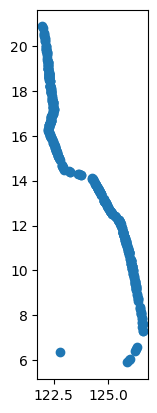

In [51]:
gdf_first_landfall_points.plot()
plt.show()

In [52]:
gdf_first_landfall_points.to_file("output/first_landfall_points.gpkg", layer="landfalls", driver="GPKG")


## For validation: check tracks of TCs with first intersecting points at west

  0%|          | 0/376 [00:00<?, ?it/s]

KeyboardInterrupt: 

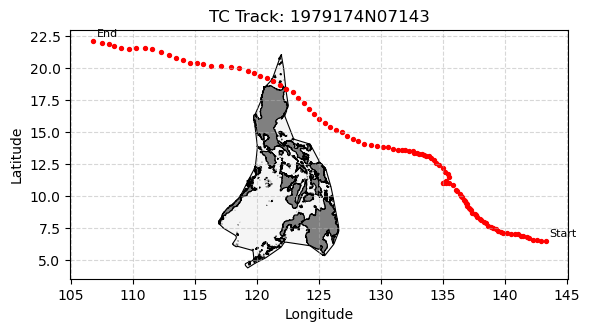

In [45]:
# Make sure output directory exists
output_dir = "plot"
os.makedirs(output_dir, exist_ok=True)

# Loop through each SID
for sid in tqdm(valid_lf_sids):
    # Filter track
    df_sid = gdf_tracks[gdf_tracks["SID"] == sid]

    # Set up plot
    fig, ax = plt.subplots(figsize=(6, 8))

    # Plot map background
    phil_waters.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.8)
    phil_coast.plot(ax=ax, color='grey', edgecolor='black', linewidth=0.8)

    # Plot TC track
    df_sid.plot(ax=ax, color='red', markersize=8, label=f"Track: {sid}")

    # Optional: annotate start and end
    if not df_sid.empty:
        ax.annotate("Start", xy=(df_sid.iloc[0].geometry.x, df_sid.iloc[0].geometry.y),
                    xytext=(3, 3), textcoords="offset points", fontsize=8)
        ax.annotate("End", xy=(df_sid.iloc[-1].geometry.x, df_sid.iloc[-1].geometry.y),
                    xytext=(3, 3), textcoords="offset points", fontsize=8)

    # Styling
    ax.set_title(f"TC Track: {sid}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    # ax.set_xlim(115, 130)
    # ax.set_ylim(5, 22)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Save figure
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{sid}.png", dpi=200)
    plt.close()

print(f"Finished plotting {len(west_sids)} tracks to {output_dir}/")